(10)
$$ \Large log\mathscr{L} = \sum_{r,i}^{N_r}[k_{i,r}\log{(\eta_{i}f_{i,r})} - \eta_{i}f_{i,r}] / k_{total} + C$$

(1) $$ \Large p_{i,r} = \frac{\eta_{i}f_{i,r}}{\sum_{r=0}^{N_r} \eta_{i}f_{i,r}} $$

(1a) $$ \Large\eta_{i}f_{i,r} = p_{i,r}\sum_{r=0}^{N_r} \eta_{i}f_{i,r} $$

Replace (1a) into (10), multiply by k_total, and remove C

(10a)
$$ \Large k_{total} log\mathscr{L}  = \sum_{r,i}^{N_r}[k_{i,r}\log{(p_{i,r}\sum_{r=0}^{N_r} \eta_{i}f_{i,r})} - \eta_{i}f_{i,r}] $$

sum of log = log of product

$$ \Large = \sum_{r,i}^{N_r}[k_{i,r}(\log{p_{i,r}} + \log{\sum_{r=0}^{N_r} \eta_{i}f_{i,r}}) - \eta_{i}f_{i,r}] $$

break down main sigma
$$ \Large = \sum_{r,i}^{N_r}k_{i,r}\log{p_{i,r}} + \sum_{r,i}^{N_r}[k_{i,r}\log{\sum_{r=0}^{N_r} \eta_{i}f_{i,r}}] - \sum_{r,i}^{N_r}\eta_{i}f_{i,r} $$

missing steps ...


(11)  $$ = \Large\sum_{r,i}^{N_r}(k_{i,r}\log{p_{r,i}})  $$

If all this is true, then the last two terms of should cancel out and be equal to zero, or 
$$ \Large \sum_{r,i}^{N_r}[k_{i,r}\log{\sum_{r=0}^{N_r} \eta_{i}f_{i,r}}] = \sum_{r,i}^{N_r}\eta_{i}f_{i,r} $$

is this true?

The terms which are different between (11) and the line after you broke down the main sigma are the following (I changed the r in the inner sum to r'):

$$ \Large \sum_{r,i}[k_{i,r}\log{\sum_{r'=0}^{N_{r'}} \eta_{r'}f_{i,r'}}] - \sum_{r,i}\eta_{r}f_{i,r} $$

Inferred from the ProboundTools Java code (CountTable.java, lines 720-732), the following equality holds for every i:

(*) $$ \Large\sum_{r'}\eta_{r'}f_{i,r'} = \Large\sum_{r'}k_{i,r'} $$

If we insert (*) into the terms in the first line, we get:

$$ \Large \sum_{r,i}[k_{i,r}\log{ \sum_{r'}k_{i,r'}}] - \sum_{r,i}k_{i,r} $$

This term does not depend on the parameters of the model. Therefore it doesn't influence the gradients, but only the value of the loss. (Maybe apart from rounding errors) these summands the same for every epoch and can be left out. Then we can indeed get (11):

$$ \Large k_{total} log\mathscr{L} = \Large\sum_{r,i}^{N_r}(k_{i,r}\log{p_{r,i}})  $$

I have implemented (11) as ProboundLoss and tested it: The R^2 score is nearly the same (0.307 with PoissonLoss vs 0.308 here)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../annotations'
# mb.models.Mubind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [4]:
n_rounds = 1
data = pd.read_csv('../../data/countTable.0.CTCF_r3.tsv.gz', sep='\t', header=None)
data.columns = ['seq'] + [i for i in range(n_rounds+1)]
# data = data.sample(n=1000)
# data.index = range(len(data))
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds)
train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

In [5]:
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12], n_rounds=1, n_batches=1).to(device)
l2 = []
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
criterion = mb.tl.ProboundLoss()

In [6]:
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=500, early_stopping=10, log_each=10)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.ProboundLoss'>
lr= 0.001
weight_decay= 0.0001
dir weight 0
Epoch:  1, Loss: 0.739358 , best epoch: -1 secs per epoch: 5.725 s
Epoch: 11, Loss: 0.348705 , best epoch: 9 secs per epoch: 5.779 s
Epoch: 21, Loss: 0.338556 , best epoch: 19 secs per epoch: 5.492 s
Epoch: 31, Loss: 0.334832 , best epoch: 29 secs per epoch: 5.401 s
Epoch: 41, Loss: 0.334754 , best epoch: 37 secs per epoch: 5.239 s
Epoch: 51, Loss: 0.334645 , best epoch: 43 secs per epoch: 5.130 s
Epoch: 61, Loss: 0.334648 , best epoch: 58 secs per epoch: 5.077 s
Epoch: 71, Loss: 0.334594 , best epoch: 61 secs per epoch: 5.064 s
Epoch: 72, Loss: 0.3345 , best epoch: 61 secs per epoch: 5.068 s
early stop!


R^2: 0.308033597040018


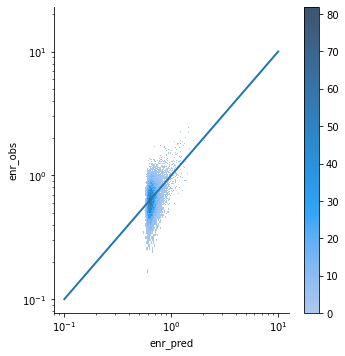

In [7]:
mb.pl.kmer_enrichment(model, train, k=8)


#activities
[[[0.9999949  0.52571785]
  [0.99998945 0.44169927]
  [0.99997514 0.5598714 ]]]

#log_etas
Parameter containing:
tensor([[ 0.8737, -0.8737]], requires_grad=True)


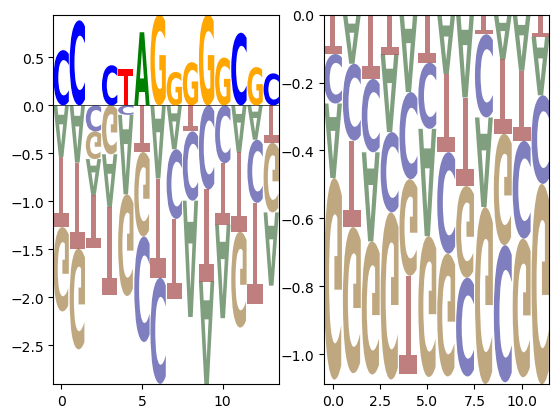

In [8]:
mb.pl.logo(model)